# Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>


## Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:
<img src="dataset/imgs/screenshot001.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="dataset/imgs/screenshot002.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## Fichiers inclus dans le starter code pour cette séance
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator



# Part 0: intro

## 0.1 imports

_Your commented code below_

In [5]:
import Prepocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pythonTools import plot_batch

## 0.2 Examen des données

Écrire des lignes de code permettant:
* de charger les données comprises dans le fichier _labels.csv_,
* de mettre en matrice les descripteurs de l'ensemble de la base d'images
* d'afficher les images avec la fonction _plot\_batch()_ du fichier \_pythonTools.py_,


_Your commented code below_

Images shape: (200, 200)
Descriptor Count: 40000 per images
Color channels: 1
Classes Count: 6 (['Posidonia' 'Ripple 45°' 'Rock' 'Sand' 'Silt' 'Ripple vertical'])


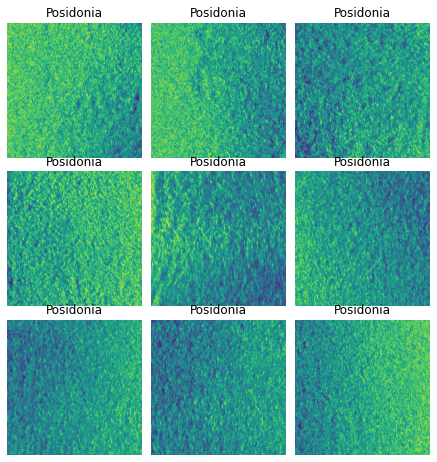

In [6]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/imgs/'
    LABEL_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/labels/labels.csv'
else:
    IN_COLAB = False
    DATASET_PATH = r'./dataset/imgs/'
    LABEL_PATH = r'./dataset/labels/labels.csv'

# Charger le fichier CSV
dataset_df = pd.read_csv(LABEL_PATH)
dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)


# Charger les images et les labels
images = np.array([plt.imread(img) for img in dataset_df['image_path'].values.tolist()])
label_names = dataset_df['seafloor'].to_numpy()

# transformer les labels en indices
label_names = dataset_df['seafloor']

label_names_unique = label_names.unique()
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names)


# rajout d'une dimension chanel pour coller au formalisme de tensorflow
images = images[...,np.newaxis]

#recuperation des metadonnées sur les images
img_shape = images.shape[1:3]
img_count = images.shape[0]
num_channels =  images.shape[3]
num_classes= np.amax(label_indices) + 1

print('Images shape: {}'.format(img_shape))
print('Descriptor Count: {} per images'.format(img_shape[0]*img_shape[1]))
print('Color channels: {}'.format(num_channels))
print('Classes Count: {} ({})'.format(num_classes, label_names_unique))

plot_batch(dataset_df, 3,3,200,200)

**Question: Quel est le nombre de données, le nombres de descripteurs**

On a donc 360 image de 200*200 pixel soit 40 000 descripteurs par image

## 0.3 prétraitements des labels

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 


_Your commented code below_

In [8]:
labels_one_hot = np.zeros((img_count, num_classes))
imag_line = np.zeros((img_count, img_shape[0] * img_shape[1]))
for i in range(img_count):
    labels_one_hot[i, label_indices[i]] = 1 #Encodage des labels en One Hot
    imag_line[i, :] = images[i].reshape((img_shape[0] * img_shape[1])) #conversion des image de 200*200 en en ligne de 40000 * 1

## 0.4 Séparation des données en ensembles 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test


_Your commented code below_

In [9]:
if np.amax(imag_line) > 1.0: #si les image sont au format 0-255
    imag_line = imag_line / 255 #transformation au format 0-1
    
ds_test = np.zeros((int(img_count/2), img_shape[0] * img_shape[1]))
labels_test = np.zeros((int(img_count/2), num_classes))
ds_train = np.zeros((int(img_count/2), img_shape[0] * img_shape[1]))
labels_train = np.zeros((int(img_count/2), num_classes))
for i in range(img_count): # recuperation de 1 image sur 2 dans chacun des sous groupes
    if i % 2 == 0:
        ds_test[int(i/2), :] = imag_line[i]
        labels_test[int(i/2), :] = labels_one_hot[i]
    else:
        ds_train[int(i/2), :] = imag_line[i]
        labels_test[int(i/2), :] = labels_one_hot[i]
        
print("nombre de d'image par classes({}):".format(label_names_unique))
print(*range(labels_one_hot.shape[1]), sep='\t|')
print(*(np.sum(labels_one_hot, axis=0)), sep='\t|')

nombre de d'image par classes(['Posidonia' 'Ripple 45°' 'Rock' 'Sand' 'Silt' 'Ripple vertical']):
0	|1	|2	|3	|4	|5
60.0	|60.0	|60.0	|60.0	|60.0	|60.0


<strong>Question: Quel est le nombre de données totales et <ins>pour chaque classe</ins>, le nombres de descripteurs pour <ins>chaque ensemble de données</ins></strong>

_votre réponse ici:_

on retrouve donc 360 images ayant chacune 40 000 descripteur, pour chaque classe on retouve 60 images 

# Part 1 approches supervisées sur données brutes

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

_votre réponse ici:_

**<ins>Question</ins>: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

_votre réponse ici:_ 

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

_Your code below_

**<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

_votre réponse ici:_

_Your code below_

**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**

_Your image here_ <img src="fichierDiagramme.png" />

# Partie 2: Approche supervisée sur descripteurs issus du scattering operator

## Chargement des descripteurs

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

_Your Code below_

## Prétraitements

**<ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

_votre réponse ici:_ 

_Your Code below_

## Apprentissage

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

_Your Code below_

## Fixer les hyper paramètres

**<ins>Question</ins>: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

_votre réponse ici:_

**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

_Your Code below_

**<ins>Question</ins>: Évaluer les résultats et donner la valeur des paramètres optimaux**

_votre réponse ici:_

_Your Code below_

## Apprendre le modèle final pour chaque classifieur

_votre réponse ici:_

_Your Code below_

## Evaluer chaque classifieur

_votre réponse ici:_ 

_Your Code below_

## Partie 4 Analyse finale des résultats


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

_votre réponse ici:_ 

_Your Code below_

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

_votre réponse ici:_